# Training Detectron2 as a Foreground Detector

by _Tobias Reaper_

The goal with this notebook is to train a proof-of-concept Detectron2 foreground detection model using the custom COCO dataset that was generated over the last couple of notebooks:

- [03 - PNG to Binary Mask](03-png-to-binary-mask.ipynb)
- [04 - PyCOCO Training Data](04-pycoco-training-data.ipynb)

Note:

> This notebook was originally developed and executed in Google Colab, and thus has some code that is specific to the platform. If you'd like to try it out for yourself, here is a link to the [Colab notebook](https://colab.research.google.com/drive/1ySAsgVUduIsF8Oy_CG8vfO3K0SFrqa5G).

---

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install detectron2

In [0]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.4.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.5.0)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-qazobrws
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-qazobrws
     |████████████████████████████████| 276kB 3.7MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=38253 sha256=97c5a18c84ea2a8db94526a93227e7af9a36f3dab0cc6d131ad01838bacc9713
  Stored in directory: /tmp/pip-ephem-wheel-cache-o4n32tgk/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pyyaml: filename=PyYAML-5.3-cp36-cp36m-linux_x86_64.whl size=44229 sha256=ac163a10a1dac44b1fdd7b5cade076743f273fcc4412ae4fb166f2e9f62f8fbb
  Stored in directory: /root/.cache/pip/wheels/e4/76/4d/a95b8dd7b452b69e8ed4f68b69e1b55e12c9c9624dd962b191
Successfully built fvcore py

'1.4.0'

In [0]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 2684, done.
remote: Total 2684 (delta 0), reused 0 (delta 0), pack-reused 2684
Receiving objects: 100% (2684/2684), 1.91 MiB | 1.72 MiB/s, done.
Resolving deltas: 100% (1819/1819), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 61kB 1.9MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Running setup.py develop for detectron2


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

---

## Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the trash panda waste foreground detection dataset](https://github.com/tobias-fyi/neurecycle/tree/master/pycoco/items/train).
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Register the items dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [0]:
# Set up filepaths to drive folder containing dataset
import os

data_dir = "/content/drive/My Drive/Colab Notebooks/items/train"

images_dir = "items_train2019"
images_path = os.path.join(data_dir, images_dir)

anno_file = "instances_items_train2019.json"
anno_path = os.path.join(data_dir, anno_file)

In [0]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("items", {}, anno_path, images_path)

In [0]:
items_metadata = MetadataCatalog.get("items")
dataset_dicts = DatasetCatalog.get("items")

[02/05 18:12:50 d2.data.datasets.coco]: Loaded 471 images in COCO format from /content/drive/My Drive/Colab Notebooks/items/train/instances_items_train2019.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



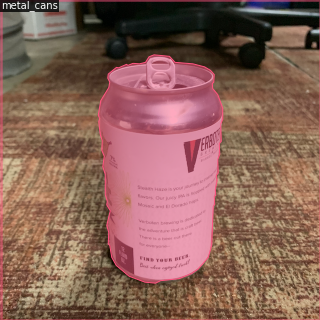

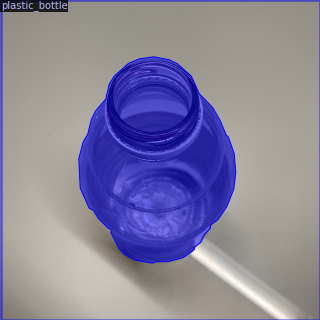

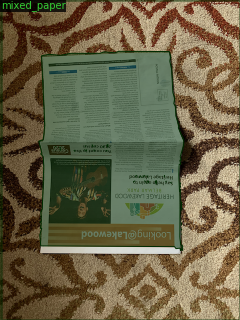

In [0]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=items_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the items dataset. It takes ~6 minutes to train 600 iterations on Colab's K80 GPU.


In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("items",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 600    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/05 18:14:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (11, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (11,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (40, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (40,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (10, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (10,) in the model! Skipped.


[02/05 18:14:09 d2.engine.train_loop]: Starting training from iteration 0
[02/05 18:14:15 d2.utils.events]: eta: 0:02:49  iter: 19  total_loss: 3.141  loss_cls: 2.289  loss_box_reg: 0.073  loss_mask: 0.692  loss_rpn_cls: 0.008  loss_rpn_loc: 0.054  time: 0.2896  data_time: 0.0126  lr: 0.000050  max_mem: 2336M
[02/05 18:14:20 d2.utils.events]: eta: 0:02:43  iter: 39  total_loss: 1.403  loss_cls: 0.602  loss_box_reg: 0.071  loss_mask: 0.670  loss_rpn_cls: 0.005  loss_rpn_loc: 0.050  time: 0.2881  data_time: 0.0043  lr: 0.000100  max_mem: 2337M
[02/05 18:14:26 d2.utils.events]: eta: 0:02:37  iter: 59  total_loss: 0.836  loss_cls: 0.104  loss_box_reg: 0.069  loss_mask: 0.601  loss_rpn_cls: 0.004  loss_rpn_loc: 0.046  time: 0.2882  data_time: 0.0039  lr: 0.000150  max_mem: 2338M
[02/05 18:14:32 d2.utils.events]: eta: 0:02:31  iter: 79  total_loss: 0.748  loss_cls: 0.084  loss_box_reg: 0.070  loss_mask: 0.524  loss_rpn_cls: 0.003  loss_rpn_loc: 0.049  time: 0.2899  data_time: 0.0056  lr: 0.0

Now, we perform inference with the trained model on the items dataset. First, let's create a predictor using the model we just trained:



In [0]:
# Save the model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

In [0]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set the testing threshold for this model
cfg.DATASETS.TEST = ("items", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

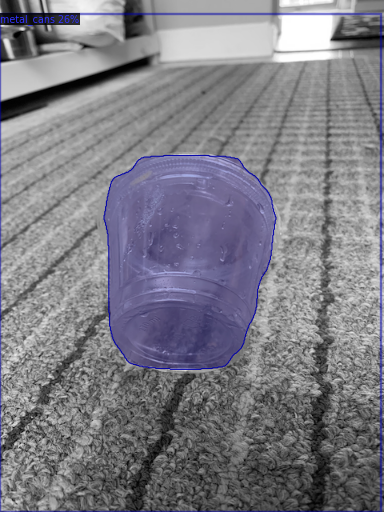

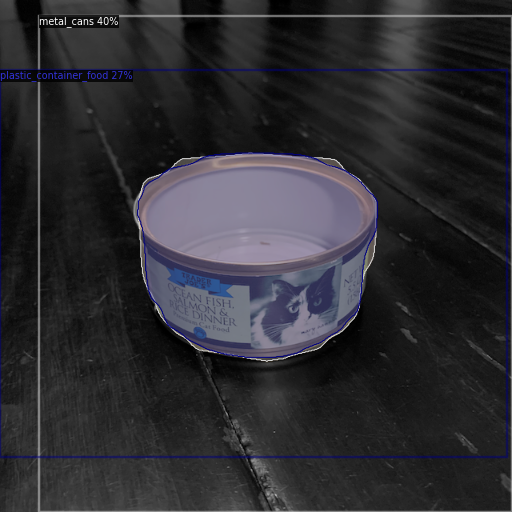

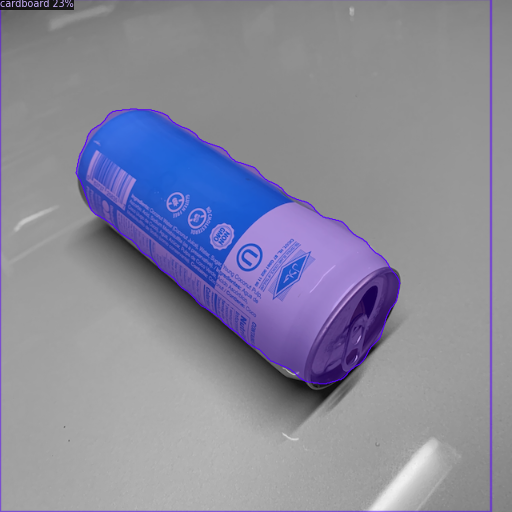

In [29]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=items_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [0]:
items_metadata

Metadata(evaluator_type='coco', image_root='/content/drive/My Drive/Colab Notebooks/items/train/items_train2019', json_file='/content/drive/My Drive/Colab Notebooks/items/train/instances_items_train2019.json', name='items', thing_classes=['cardboard', 'glass_container', 'metal_cans', 'mixed_paper', 'paper_treated', 'plastic_bottle', 'plastic_bubblewrap', 'plastic_container_food', 'plastic_film', 'wrapper'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9})

## Benchmark inference speed

In [30]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.08,fps:13.24
